# Model Training (TEST)

In [ ]:
# This is for adding features to the auto model trainer

In [1]:
import sys
    
default_args = {
    'learning_rate' : 5e-5,
    'epochs' : 20,
    'batch_size' : 64,
    'model' : 'xlm-roberta-base',
    'exp_desc' : 'default_run'
}

sys.argv = ["script_name", "--learning_rate", str(default_args["learning_rate"]) ,"--epochs", str(default_args["epochs"]),"--batch_size", str(default_args["batch_size"]),"--model" , default_args["model"]]


In [2]:
import numpy as np
from sklearn.metrics import confusion_matrix

def confusion_matrix(model, test_data):
    
    # Assuming you have a trained model and test dataset
    predictions = np.argmax(model.predict(test_data), axis=1)

    true_labels = test_labels  # Ground truth labels
    conf_matrix = confusion_matrix(true_labels, predictions)
    
    print("Confusion Matrix:")
    print(conf_matrix)

2025-04-18 13:58:59.101020: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-18 13:58:59.130436: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-18 13:58:59.130480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-18 13:58:59.131375: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-18 13:58:59.138915: I tensorflow/core/platform/cpu_feature_guar

Learning Rate: 5e-05, Epochs: 20, Batch Size: 64 Model: xlm-roberta-base Exp Des: None
||--------------------------------------||
||===>> Starting run: XLM-RoBERTa__lr5e-05_ep20_bs64 with hyperparameters: {'learning_rate': 5e-05, 'epochs': 20, 'batch_size': 64}
||--------------------------------------||
TensorFlow version: 2.15.0
GPUs detected:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2025-04-18 13:59:02.772040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-18 13:59:02.803223: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-18 13:59:02.803282: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-18 13:59:04.371617: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-18 13:59:04.371769: I external/local_xla/xla/stream_executor

Epoch 1/20
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2025-04-18 13:59:38.027708: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9996346010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-18 13:59:38.027759: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-04-18 13:59:38.055200: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-18 13:59:38.106556: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1744955978.182687    2301 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     70/Unknown - 38s 117ms/step - loss: 0.6873 - accuracy: 0.5550

2025-04-18 13:59:46.699026: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 16254079312429798127
2025-04-18 13:59:46.699146: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5371712453003769313
2025-04-18 13:59:46.699154: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17469599708278458229
2025-04-18 13:59:46.699162: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5978835562231550284
2025-04-18 13:59:46.699165: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3264293967362184940
2025-04-18 13:59:46.699169: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15531967402500245470
2025-04-18 13:59:46.699171: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send 


Epoch 1: val_loss improved from inf to 0.68009, saving model to ./checkpoints/XLM-RoBERTa__lr5e-05_ep20_bs64.h5
70/70 [==============================] - 51s 311ms/step - loss: 0.6873 - accuracy: 0.5550 - val_loss: 0.6801 - val_accuracy: 0.5142
Epoch 2/20
70/70 [==============================] - ETA: 0s - loss: 0.6654 - accuracy: 0.6343 
Epoch 2: val_loss improved from 0.68009 to 0.66920, saving model to ./checkpoints/XLM-RoBERTa__lr5e-05_ep20_bs64.h5
70/70 [==============================] - 61s 884ms/step - loss: 0.6654 - accuracy: 0.6343 - val_loss: 0.6692 - val_accuracy: 0.5445
Epoch 3/20
70/70 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.6697 
Epoch 3: val_loss improved from 0.66920 to 0.65407, saving model to ./checkpoints/XLM-RoBERTa__lr5e-05_ep20_bs64.h5
70/70 [==============================] - 24s 348ms/step - loss: 0.6511 - accuracy: 0.6697 - val_loss: 0.6541 - val_accuracy: 0.6883
Epoch 4/20
70/70 [==============================] - ETA: 0s - loss: 0

2025-04-18 14:14:07.984376: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 370077143466096550
2025-04-18 14:14:07.984600: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 1071974230409750221
2025-04-18 14:14:07.984621: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 18387386125361395441


8/8 [==============================] - 6s 137ms/step
||-------------------------------------------------------||
||--> Run XLM-RoBERTa__lr5e-05_ep20_bs64 evaluation metrics output:
Accuracy: 0.7976, Precision: 0.7567, Recall: 0.8937, F1-Score: 0.8195
||-------------------------------------------------------||
Confusion Matrix:
[[167  73]
 [ 27 227]]


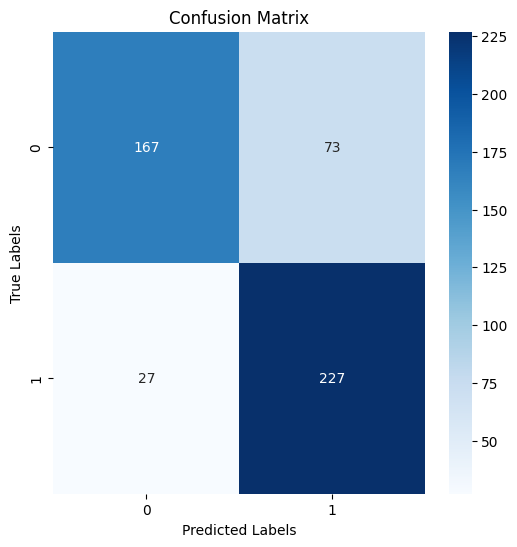

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import os
import tensorflow as tf
import itertools
import gc
import mlflow

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import random

import argparse

MAX_LENGTH = 12
BATCH_SIZE = 16
EPOCHS = 100

randnum = 10#42

mlflow.sklearn.autolog()

# Load dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[['text', 'label']].dropna()
    df['label'] = df['label'].astype(int)
    return df

# Tokenization function
def tokenize_data(texts, tokenizer):
    return tokenizer.batch_encode_plus(
        texts,
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

# Prepare datasets
def prepare_datasets(train_df, val_df, test_df, tokenizer):
    train_encodings = tokenize_data(train_df['text'].tolist(), tokenizer)
    val_encodings = tokenize_data(val_df['text'].tolist(), tokenizer)
    test_encodings = tokenize_data(test_df['text'].tolist(), tokenizer)

    train_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': train_encodings['input_ids'],
            'attention_mask': train_encodings['attention_mask']
        },
        train_df['label'].values
    )).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': val_encodings['input_ids'],
            'attention_mask': val_encodings['attention_mask']
        },
        val_df['label'].values
    )).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    test_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': test_encodings['input_ids'],
            'attention_mask': test_encodings['attention_mask']
        },
        test_df['label'].values
    )).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset, test_dataset

def model_abbre(model_name):
    cases = {
        "bert-base-uncased": "bert-base",
        "bert-base-multilingual-cased": "mBERT",
        'xlm-roberta-base': 'XLM-RoBERTa' 
        #'google-bert/bert-base-cased': 'mobileBert'
    }
    return cases.get(model_name, "Model Unavailable")
    
def run_training(hp, model_name):
    mlflow.set_experiment("Second Evaluation")
    run_name = f"{model_abbre(model_name)}__lr{hp['learning_rate']}_ep{hp['epochs']}_bs{hp['batch_size']}"
    with mlflow.start_run(run_name=run_name):
        mlflow.log_params(hp)
        mlflow.set_tag("model_name", model_name)
        mlflow.log_param("model", model_name)
        print("||--------------------------------------||")        
        print(f"||===>> Starting run: {run_name} with hyperparameters: {hp}")
        print("||--------------------------------------||")        

        #Red Info Logs Killer
        os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
        
        # Print the TensorFlow version
        print(f"TensorFlow version: {tf.__version__}")
        
        # List available GPU devices
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            print("GPUs detected:")
            for gpu in gpus:
                print(gpu)
        else:
            print("No GPUs detected.")
            
        if gpus:
            tf.config.experimental.set_memory_growth(gpus[0], True)
        
            # Configuration
        MODEL_NAME = model_name # also for tokenizer
        
                                         # 'bert-base-uncased' (bert)
                                         # 'bert-base-multilingual-cased' (mBERT)
                                         # 'xlm-roberta-base' or "distilroberta-base" (XLM-RoBERTa, Distil Roberta)
                                         # "google-bert/bert-base-cased" (mobileBert)
        
        random.seed(randnum)
        tf.random.set_seed(randnum)
        np.random.seed(randnum)
        
        model_output_name = "mbert_logging_test1"


        # Dataset split
        df = load_data('dataset/finaldataset_6k_shuffled_v2.csv')
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=randnum)
        train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=randnum)
        
        # Initialize tokenizer
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

        train_dataset, val_dataset, test_dataset = prepare_datasets(train_df, val_df, test_df, tokenizer)

        # Model initialization
        model = TFAutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME,
            num_labels=2,
            # hidden_dropout_prob=0.3,
            # attention_probs_dropout_prob=0.15
        )
        
        # Freeze all layers
        for layer in model.layers:
            layer.trainable = False
        # Unfreeze classifier layer
        model.layers[-1].trainable = True
        
        # Compile the model
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp["learning_rate"])
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    
        # Prepare datasets
        train_ds = train_dataset.unbatch().batch(hp["batch_size"])
        val_ds = val_dataset.unbatch().batch(hp["batch_size"])

        # Prepare callbacks: EarlyStopping and ModelCheckpoint
        checkpoint_filepath = f"./checkpoints/{run_name}.h5"
        os.makedirs(os.path.dirname(checkpoint_filepath), exist_ok=True)
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            tf.keras.callbacks.TensorBoard(log_dir='logs'),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                monitor='val_loss',
                save_best_only=True,
                save_weights_only=True,
                verbose=1
            ),
            tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: [
                mlflow.log_metric("train_loss", logs["loss"], step=epoch),
                mlflow.log_metric("train_accuracy", logs["accuracy"], step=epoch),
                mlflow.log_metric("val_loss", logs["val_loss"], step=epoch),
                mlflow.log_metric("val_accuracy", logs["val_accuracy"], step=epoch),
            ])
        ]
        
        # Train the model
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=hp["epochs"],
            callbacks=callbacks,
            verbose=1
        )
    
        # Optionally load best checkpoint
        if os.path.exists(checkpoint_filepath):
            model.load_weights(checkpoint_filepath)
        
        # Evaluate the model
        val_preds = model.predict(val_ds).logits
        y_pred = np.argmax(val_preds, axis=1)
        y_true = np.concatenate([y for x, y in val_ds], axis=0)
        
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        print("||-------------------------------------------------------||")
        print(f"||--> Run {run_name} evaluation metrics output:")
        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}")
        print("||-------------------------------------------------------||")
        # Log metrics to MLflow
        mlflow.log_metrics({
            "val_accuracy": acc,
            "val_precision": prec,
            "val_recall": rec,
            "val_f1_score": f1
        })

        # Compute confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:")
        print(conf_matrix)
        
        # Plot confusion matrix
        plt.figure(figsize=(6, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()

        # Clean up GPU memory
        del model
        gc.collect()
        tf.keras.backend.clear_session()

    

if __name__ == "__main__":

    
    parser = argparse.ArgumentParser()
    parser.add_argument("--learning_rate", type=float, required=True)
    parser.add_argument("--epochs", type=int, required=True)
    parser.add_argument("--batch_size", type=int, required=True)
    parser.add_argument("--model", type=str, required=True)
    parser.add_argument("--exp_desc", type=str, required=False)
    args = parser.parse_args()

    print(f"Learning Rate: {args.learning_rate}, Epochs: {args.epochs}, Batch Size: {args.batch_size} Model: {args.model} Exp Des: {args.exp_desc}")

    # Model Names: 
    # 'bert-base-uncased' (bert)
    # 'bert-base-multilingual-cased' (mBERT)
    # 'xlm-roberta-base' or "distilroberta-base" (XLM-RoBERTa, Distil Roberta)
    # "google-bert/bert-base-cased" (mobileBert)

    # Prepare hyperparameter dictionary
    hyperparams = {
        "learning_rate": args.learning_rate,
        "epochs": args.epochs,
        "batch_size": args.batch_size
    }
    
    run_training(hyperparams, args.model)